# Empirical Application 2 Financial Econometrics

*By Daniel Deutsch, José Lucas Barretto, and Stéphane Roblet*

In [1]:
import warnings

import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Importing Datasets

The first thing we need to do here is get ourselves the data. We did it by downloading them as .csv in the following links:

- https://fred.stlouisfed.org/series/DAAA
- https://data.nasdaq.com/data/MULTPL/SP500_DIV_YIELD_MONTH-sp-500-dividend-yield-by-month
- https://fred.stlouisfed.org/series/IRLTLT01USM156N


In [3]:
# Import data
df_aaa = pd.read_csv("datasets/aaa.csv", names=['date', 'value'], parse_dates=['date'], skiprows=[0], na_values='.')
df_govbonds = pd.read_csv("datasets/govbonds.csv", names=['date', 'value'], parse_dates=['date'], skiprows=[0], na_values='.')
df_sp500 = pd.read_csv("./datasets/sp500.csv", names=['date', 'value'], parse_dates=['date'], skiprows=[0], na_values='.')

# Ignore day in datetime
df_aaa['date'] = df_aaa['date'].astype('datetime64[M]')
df_govbonds['date'] = df_govbonds['date'].astype('datetime64[M]')
df_sp500['date'] = df_sp500['date'].astype('datetime64[M]')

# Drop duplicates
df_aaa.drop_duplicates('date', inplace=True, ignore_index=True)
df_govbonds.drop_duplicates('date', inplace=True, ignore_index=True)
df_sp500.drop_duplicates('date', inplace=True, ignore_index=True)

# Remove not available data
df_aaa.dropna(inplace=True)
df_govbonds.dropna(inplace=True)
df_sp500.dropna(inplace=True)

# Removing Stochastic Trends

As we saw in the previous empirical application, the first difference of each one of our time series is stationary, so their trend coefficient is tested to be statistically insignificant. Therefore, we can proceed by using the first difference of each series to build our VAR model.

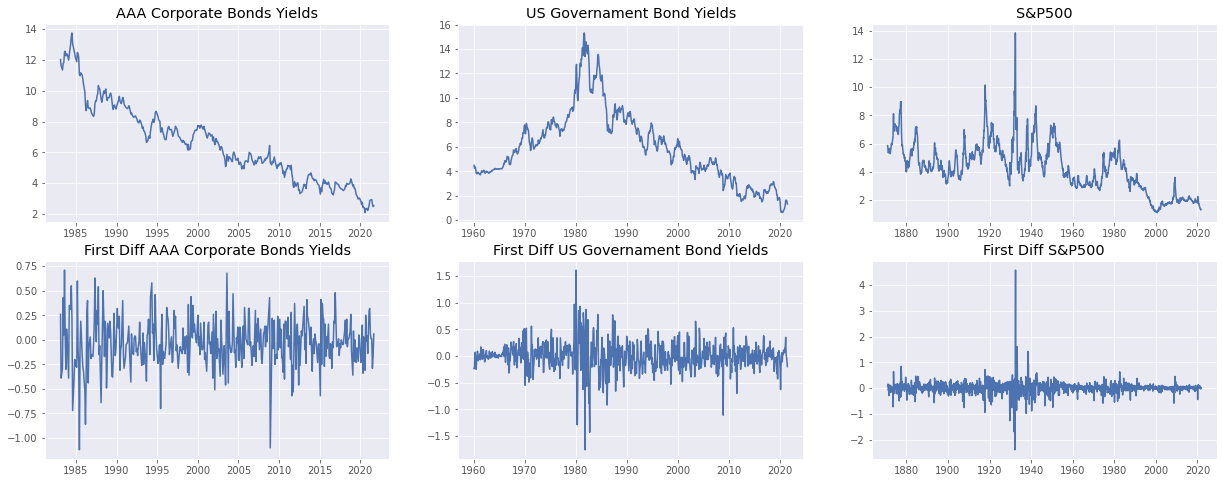

In [4]:
# Obtains the first difference
df_aaa['diff'] = df_aaa['value'].diff()
df_govbonds['diff'] = df_govbonds['value'].diff()
df_sp500['diff'] = df_sp500['value'].diff()

# Remove not available data
df_aaa.dropna(inplace=True)
df_govbonds.dropna(inplace=True)
df_sp500.dropna(inplace=True)

# Plot the original series and it's first difference
fig, axs = plt.subplots(2, 3, figsize=(21, 8))
axs[0, 0].plot(df_aaa['date'], df_aaa['value'])
axs[0, 0].set_title("AAA Corporate Bonds Yields")
axs[1, 0].plot(df_aaa['date'], df_aaa['diff'])
axs[1, 0].set_title("First Diff AAA Corporate Bonds Yields")
axs[0, 1].plot(df_govbonds['date'], df_govbonds['value'])
axs[0, 1].set_title("US Governament Bond Yields")
axs[1, 1].plot(df_govbonds['date'], df_govbonds['diff'])
axs[1, 1].set_title("First Diff US Governament Bond Yields")
axs[0, 2].plot(df_sp500['date'], df_sp500['value'])
axs[0, 2].set_title("S&P500")
axs[1, 2].plot(df_sp500['date'], df_sp500['diff'])
axs[1, 2].set_title("First Diff S&P500")
plt.show()

# VAR Model Estimations

For our desired analysis, we must garantee that all our time series have a time intersection (i.e. the data collected concerns the same time interval) to enable our comparissons. In our case, we can see that the intersection happens between 1983 and 2021.  

In [5]:
df = pd.merge(df_aaa[['date', 'diff']], df_govbonds[['date', 'diff']], on='date', how='inner').rename(columns={ 'diff_x': 'diff_aaa', 'diff_y': 'diff_govbonds' })
df = df.merge(df_sp500[['date', 'diff']], on='date', how='inner').rename(columns={ 'diff': 'diff_sp500' })
df.set_index('date', inplace=True)
df

,diff_aaa,diff_govbonds,diff_sp500
date,,,
1983-02-01,0.26,0.26,0.15
1983-03-01,-0.39,-0.21,0.16
1983-05-01,-0.29,-0.02,0.05
1983-06-01,0.43,0.47,0.00
1983-07-01,0.05,0.53,-0.13
...,...,...,...
2021-03-01,0.32,0.35,0.08
2021-04-01,0.06,0.03,0.00
2021-05-01,0.01,-0.02,0.02


## Test-Train Data Split

We split our data into training (75%) and testing (25%) data.

In [6]:
nobs = 2
df_train, df_test = df[0:-nobs], df[-nobs:]

print(f"Training shape: {df_train.shape}, testing shape: {df_test.shape}")

Training shape: (406, 3), testing shape: (2, 3)


## Causality Test

The idea behind the VAR Model is that each of the series considered has a causality effect over the others. Thus, we shall first test if this statement is true in our case via the Granger Causality Test, which considers the following hypotesis:

$
\begin{aligned}
    H_0: & \quad \text{The coefficients corresponding to past values of the second time series are zero (there is no causality).} \\
    H_1: & \quad \text{ the coefficients corresponding to past values of the second time series are not zero (there is causality).}
\end{aligned}
$

Once the Granger Causality Test is performed and we have obtained our results, we should consider the following to take our conclusions:

- If the p-value is lower than 0.05, than we must reject the null hypotesys (and, consequently, accept the alternativel one).
- If the p-value is slightly above 0.05, then the critical values should be used to judge whether to reject the null hypotesis.

In [7]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=12):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_train, df_train.columns)

,diff_aaa_x,diff_govbonds_x,diff_sp500_x
diff_aaa_y,1.0000,0.0000,0.0000
diff_govbonds_y,0.0000,1.0000,0.0066
diff_sp500_y,0.0002,0.0186,1.0000


The matrix printed above shows the p-value of the test that measures the causality that the variable x has in the variable y, i.e., if a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row). 

Therefore, by observing the obtained results, one can conclude that, at the 5% level, all our variables have a causality effect over the others. 

## Selecting the Order of the Model

To obtain the best parameter for the VAR model we run a grid search using the AIC score (select the model with the lowest AIC).

In [8]:
df_scores = pd.DataFrame()
best_fit = None
for p in range(10):
    model = VAR(df_train)
    model_fit = model.fit(p)
    df_scores = df_scores.append({
        'order': p,
        'AIC': model_fit.aic,
        'BIC': model_fit.bic, 
        'FPE': model_fit.fpe, 
        'HQIC': model_fit.hqic
    }, ignore_index=True)
    best_fit = model_fit if p == 0 else model_fit if model_fit.aic < best_fit.aic else best_fit
    
display(df_scores)
print(f"\nFrom the results shown above we can see that the model that uses {best_fit.k_ar} lags is the optimal one.\n")

,order,AIC,BIC,FPE,HQIC
0,0.0,-10.951317,-10.921714,0.000018,-10.939601
1,1.0,-11.470406,-11.351773,0.000010,-11.423449
2,2.0,-11.515296,-11.307302,0.000010,-11.432960
3,3.0,-11.500777,-11.203090,0.000010,-11.382924
4,4.0,-11.471541,-11.083826,0.000010,-11.318031
5,5.0,-11.471292,-10.993211,0.000010,-11.281984
6,6.0,-11.466576,-10.897792,0.000010,-11.241330
7,7.0,-11.430338,-10.770509,0.000011,-11.169011
8,8.0,-11.404129,-10.652913,0.000011,-11.106579
9,9.0,-11.376328,-10.533379,0.000011,-11.042410



From the results shown above we can see that the model that uses 2 lags is the optimal one.



In [9]:
best_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 03, Oct, 2021
Time:                     15:38:29
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -11.3073
Nobs:                     404.000    HQIC:                  -11.4330
Log likelihood:           627.336    FPE:                9.97643e-06
AIC:                     -11.5153    Det(Omega_mle):     9.47531e-06
--------------------------------------------------------------------
Results for equation diff_aaa
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.011927         0.009658           -1.235           0.217
L1.diff_aaa             -0.486820         0.058896           -8.266           0.000
L1.diff_govbonds         0.738752         0.0

## Forecasting at Horizon 2

In [10]:
p = best_fit.k_ar
forecast = best_fit.forecast(df.values[-p:], steps=nobs)
df_forecast = pd.DataFrame(forecast, index=df.index[-nobs:], columns=df.columns)
df_forecast

,diff_aaa,diff_govbonds,diff_sp500
date,,,
2021-06-01,-0.054140,-0.014126,0.006819
2021-07-01,-0.011953,-0.005018,0.018720


In [11]:
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

df_results = invert_transformation(df_train, df_forecast) 
df_results

,diff_aaa,diff_govbonds,diff_sp500,diff_aaa_forecast,diff_govbonds_forecast,diff_sp500_forecast
date,,,,,,
2021-06-01,-0.054140,-0.014126,0.006819,-0.044140,-0.034126,0.026819
2021-07-01,-0.011953,-0.005018,0.018720,-0.056093,-0.039144,0.045539


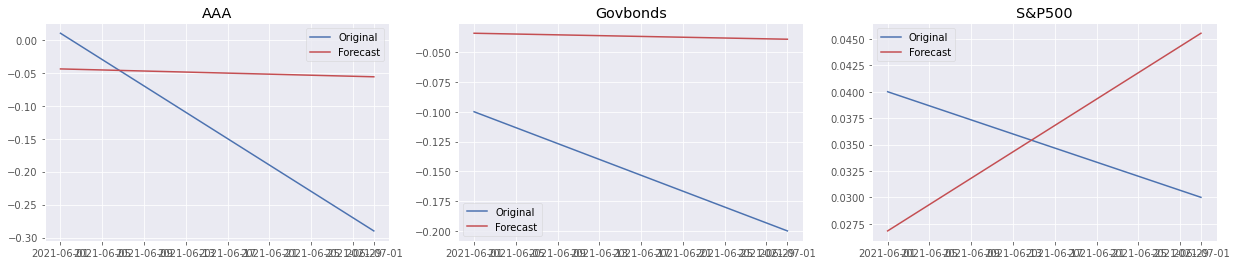

In [12]:
# Plot the original series and it's first difference
fig, axs = plt.subplots(1, 3, figsize=(21, 4))
axs[0].plot(df_test['diff_aaa'], label="Original")
axs[0].plot(df_results['diff_aaa_forecast'], label="Forecast")
axs[0].set_title("AAA")
axs[0].legend()
axs[1].plot(df_test['diff_govbonds'], label="Original")
axs[1].plot(df_results['diff_govbonds_forecast'], label="Forecast")
axs[1].set_title("Govbonds")
axs[1].legend()
axs[2].plot(df_test['diff_sp500'], label="Original")
axs[2].plot(df_results['diff_sp500_forecast'], label="Forecast")
axs[2].set_title("S&P500")
axs[2].legend()
plt.show()